# NPT  ensumble for equation of state 

http://www.fhi-berlin.mpg.de/~luca/Course_TU/02_Metropolis_MonteCarlo.pdf

In [1]:
import numpy as np 
import math
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

from numba import jit

In [2]:
sigma   = 1
L =  100
npart = 32
pressure = 1
dL_max = 0.1
dx = 1.0/16
halfL = L/2

#z=1 #exp(mu)

In [3]:
# Some helper functions
@jit
def wrap(particle):
    '''Apply perodic boundary conditions.'''
    if particle >= L:
        particle -= L
    elif particle < 0:
        particle += L
    return particle

In [4]:
@jit
def Vext_cal(x,a,b,c):
    V=0
    return V    

/home/sam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


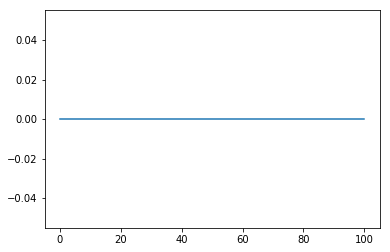

In [5]:
x= np.linspace(0,L,32//dx)
Vext = np.zeros(int(32/dx))
for i in range (int(32/dx)):
    Vext[i]=Vext_cal(i*L/32*dx,1,L/4,3)
plt.plot(x,Vext)


In [6]:
@jit
def distancesq(x1, x2,L):
    '''Gets the squared distance between two particles, applying the minimum image convention.'''
    # Calculate distances
    Dx = np.abs(x1-x2)
    if Dx > L/2:
        Dx -= L
    return Dx**2

In [7]:
@jit
def energy(particles,epsilon,a,b,c,L):
    '''Gets the energy of the system'''
    energy = 0.
    
    for i in range(npart):
        for j in range(npart):
            if(i!=j):
                dist = distancesq(particles[i], particles[j],L)
                if(dist**0.5<16):
                    energy += 4.*epsilon*((1/dist**6)-(1/dist**3))
                if(dist<1):
                    return 10**8
    energy/=2
    
    for i in range(npart):
        energy+=Vext_cal(particles[i],a,b,c)
    
    return energy 

In [8]:
@jit
def particleEnergy(particle,p,particles,epsilon,a,b,c,L):
    '''Gets the energy of a single particle.'''
    part_energy = 0.
    
    for i in range(npart):
        if(i!=p):
            dist = distancesq(particle, particles[i],L)
            if(dist**0.5<16):
                part_energy += 4*epsilon*((1/dist**6)-(1/dist**3))
            if(dist<1):
                return 10**8
    
    part_energy+=Vext_cal(particle,a,b,c)
    
    return part_energy

In [9]:
# Initialize the simulation box:
@jit
def initial(L):
    particles = np.zeros(npart)
    
    for i in range(npart):
        x_coord = np.random.uniform(0, L)
        particles[i]=i*L/npart
        #prop = random.uniform(0, 1)
        #if(prop>=0.5):
        #    exist[i]=1
    return particles

In [10]:
@jit
def MC_step(particles,L,pressure,steps,eps,a,b,c,Print=True):
    for step in range(0, steps):
        prop = np.random.uniform(0, 1)#volumn or move
        if (prop*(npart+1) + 1 < npart):
            for i in range(npart):
                # Move particle and evaluate energy
                this_particle = np.copy(particles[i])
                prev_E = particleEnergy(this_particle,i, particles, eps,a,b,c,L)
                this_particle =np.random.uniform(0, L)
                new_E =  particleEnergy(this_particle,i, particles, eps,a,b,c,L)
                deltaE = new_E - prev_E
                rand = np.random.uniform(0,1)
                #if(deltaE<10**3):
                if (np.exp(-deltaE) > rand):
                    particles[i] = this_particle
                
        else:
            oldL =  L
            rand = np.random.uniform(-0.5, 0.5)
            #Suggest a random volume by preforming a random walk in lnV.
            lnLTrial = np.log(oldL*(1+rand*dL_max)) 
            LTrial = np.exp(lnLTrial)
            newL = LTrial
            coordsTrial = particles*(newL/oldL)
            energy_old = energy(particles,eps,a,b,c,oldL)
            energy_new = energy(coordsTrial,eps,a,b,c,newL)
            weight=(energy_new - energy_old) + pressure*(newL - oldL) - (npart+1)*np.log(newL/oldL)
            
            rand = np.random.uniform(0, 1)
            #if(weight<10**3):
            if (rand < np.exp(-weight)):
                L = newL
                particles*=(newL/oldL)
                if(L<npart):
                    print(particles,L)
    return particles,energy(particles,eps,a,b,c,L),L

In [11]:
@jit
def MC_result(seed,L,pressure,eps,a,b,c):
    np.random.seed(seed)
    particles = initial(L)
    "warm up"
    particles, ene ,L= MC_step(particles,L,pressure,10**5,eps,a,b,c) # better > 10**5
    print("WARM UP",ene,L)
    avg_step = 10**4 # better > 10**4
    ene_array = np.zeros(0)
    L_array = np.zeros(0)
    ene_array=np.append(ene_array,energy)
    L_array=np.append(L_array,L)
    for i in range(avg_step-1):
        np.random.seed(i)
        particles, ene,L = MC_step(particles,L,pressure,1024,eps,a,b,c,Print=False)
        ene_array=np.append(ene_array,ene)
        L_array=np.append(L_array,L)
        #rho += density_cal(particles)

        if(i%1000==0):
            print(i,ene,L)
    #rho=rho/avg_step
    #print("energy_avg",np.sum(ene_array)/len(ene_array),
    #      np.sum(L_array)/len(L_array))
    return particles,ene_array,L_array


def density_result(seed,L,pressure,eps):
    """
    density = random.uniform(0.3,0.5)
    a=random.uniform(1,3)
    b=random.uniform(0,1)
    c=random.uniform(1,L/8)
    """
    a=0
    b=0
    c=0
    particles,energy,L_array = MC_result(seed,L,pressure,eps,a,b,c)
    return particles,energy,L_array

In [12]:
N=20
#P_array=np.exp(np.linspace(np.log(0.01),np.log(1),N))
P_array=np.linspace(0.01,8,N)

rho_array=np.zeros(N)
eps = 1.5
L=npart/np.min(P_array)
for i in range (N):
    print(i,"/",N)
    particles,energy_array,L_array=density_result(123,L,P_array[i],eps)
    rho_array[i]=npart/np.mean(L_array)
    L=np.mean(L_array)
    np.savetxt("P_rho_eps_"+str(eps)+".dat",np.vstack((P_array,rho_array)))


0 / 20
WARM UP -0.10593191302774478 3105.1899293846595
0 -0.6306963779746114 2804.081889972299
1000 -0.08549037587656175 2804.0573157678014
2000 -0.06317274493050999 3360.7834722390226
3000 -0.0017672589868192728 3471.1308538319918
4000 -2.7804138169213246 2660.1925681127873
5000 -2.3139525623061363 4426.143344575721
6000 -1.0412748977119726 3313.128568872961
7000 -0.4322782791144146 4297.40600572677
8000 -1.3932108259714089 2032.639142839701
9000 -1.1118155334395236e-05 4362.444764636256
1 / 20
WARM UP -14.481535229926614 103.33849649961728
0 -16.530052784916812 76.82577394858046
1000 -13.20142448538874 94.12003581271095
2000 -20.162470502752466 91.96930797985381
3000 -13.387284803496529 101.86184368027773
4000 -15.040674999282956 77.37586872038031
5000 -14.937689656452573 96.42667472475517
6000 -11.530979820967074 84.17358542765929
7000 -12.813060519431858 108.22221262141926
8000 -19.500845363018986 79.49763975712071
9000 -11.785445477901286 117.10352669070397
2 / 20
WARM UP -16.6831

2000 -36.057672136558715 36.544128736095274
3000 -43.74372568327268 35.96721790821533
4000 -39.9824247001384 35.97035318854386
5000 -42.044523482589085 36.798121995426065
6000 -39.90119067066698 38.48051399162229
7000 -38.20593162570691 37.838257683473344
8000 -40.4254202490136 35.848724340306205
9000 -41.574981708515026 37.02391620510916
18 / 20
WARM UP -36.919994981597625 35.08508463613421
0 -41.14164763386066 35.170654229414524
1000 -41.30174525383547 35.40669304229441
2000 -40.98508967518608 35.52793320603315
3000 -41.39089158994342 36.14654759606226
4000 -39.288107731692556 36.02141876611881
5000 -41.977848431090216 35.78861559692325
6000 -44.018797712265936 36.02972149115271
7000 -38.96469202220783 36.455459592567685
8000 -40.776316453197765 35.966698440808614
9000 -42.08390079206117 36.48548605390585
19 / 20
WARM UP -39.947722215955125 35.961910056613824
0 -40.82751973013602 36.10643703903267
1000 -41.788824279153474 35.56017374278234
2000 -39.78899675682947 36.2690391173387
300

In [13]:
np.savetxt("P_rho_eps_"+str(eps)+".dat",np.vstack((P_array,rho_array)))

In [14]:
rho_array,P_array

(array([0.01000463, 0.36623773, 0.55996602, 0.66350858, 0.72301082,
        0.76114228, 0.78737706, 0.80625871, 0.82131833, 0.83204421,
        0.84106939, 0.8502264 , 0.85648664, 0.86279971, 0.86836449,
        0.87262322, 0.87769578, 0.88085218, 0.88521643, 0.88900804]),
 array([0.01      , 0.43052632, 0.85105263, 1.27157895, 1.69210526,
        2.11263158, 2.53315789, 2.95368421, 3.37421053, 3.79473684,
        4.21526316, 4.63578947, 5.05631579, 5.47684211, 5.89736842,
        6.31789474, 6.73842105, 7.15894737, 7.57947368, 8.        ]))

In [15]:
particles,energy_array,L_array=density_result(123,L,np.log(8),0.5)

WARM UP -9.325135308789577 47.00607833486584
0 -10.87201440327904 44.58630248317658
1000 -9.950457224136219 42.267524927794696
2000 -7.138030970491943 47.25322515852629
3000 -8.64941420552877 46.98136984185395
4000 -9.489655682834544 43.6236384081035
5000 -8.41640369382065 46.937131973854385
6000 -8.880957483578303 49.68093217159779
7000 -8.817640675778055 46.548837354148255
8000 -10.0887905409919 43.04579940284934
9000 -7.3749709134197925 51.01895053073026


In [16]:
npart/np.mean(L_array)

0.7004449510096982

In [17]:
#fig, ax1 = plt.subplots()
#ax1.plot(L_array,"r")

In [18]:
#rho_avg = npart/np.mean(L_array)

In [19]:
def P_hr(rho):
    return rho/(1-rho)

In [20]:
#P_hr(rho_avg),pressure

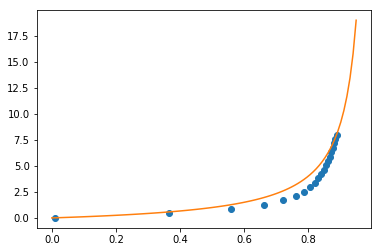

In [21]:
plt.plot(rho_array,P_array,"o")
x = np.linspace(0,0.95,100)
plt.plot(x,P_hr(x))


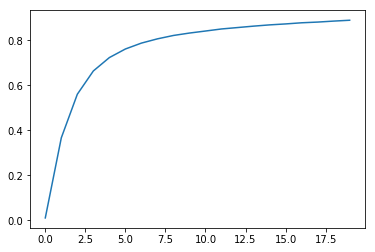

In [22]:
plt.plot(rho_array)

In [23]:
P_rho=np.loadtxt("P_rho_eps_"+str(eps)+".dat")

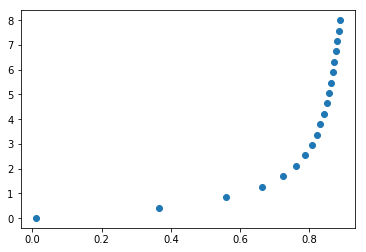

In [24]:
plt.plot(P_rho[1],P_rho[0],"o")